<a href="https://colab.research.google.com/github/OlegV12/ML_in_business/blob/Lesson_4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево
Ссылки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.ensemble import RandomForestClassifier

In [2]:
!pip install scikit-uplift==0.2.0

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
df = pd.read_csv('/gdrive/MyDrive/data.csv')

In [5]:
df.rename(columns={'conversion':'target', 'offer': "treatment"}, inplace=True)


In [6]:
df.loc[(df['treatment'] == 'Buy One Get One') | (df['treatment'] == 'Discount'), 'treatment'] = 1
df.loc[(df['treatment'] == 'No Offer'), 'treatment'] = 0

In [7]:
df


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [8]:
df = pd.get_dummies(df, columns=(['zip_code', 'channel']))

In [9]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.149422,0.449625,0.400953,0.121281,0.437828,0.440891
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.356507,0.497460,0.490095,0.326456,0.496123,0.496498
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0, test_size=0.30)

In [11]:
indices_train = X_train.index
indices_test = X_test.index

In [12]:
indices_train

Int64Index([26161, 10495, 50047, 56688, 62760, 58439, 55939,  6202,  8708,
            53518,
            ...
            57043, 41993, 32103, 30403, 21243, 45891, 52416, 42613, 43567,
             2732],
           dtype='int64', length=44800)

In [13]:
treat_train = df.loc[indices_train, 'treatment']
treat_test = df.loc[indices_test, 'treatment']

In [14]:
treat_train

26161    1
10495    1
50047    1
56688    0
62760    1
        ..
45891    0
52416    1
42613    1
43567    1
2732     1
Name: treatment, Length: 44800, dtype: object

In [15]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

uplift@30%: 0.0812


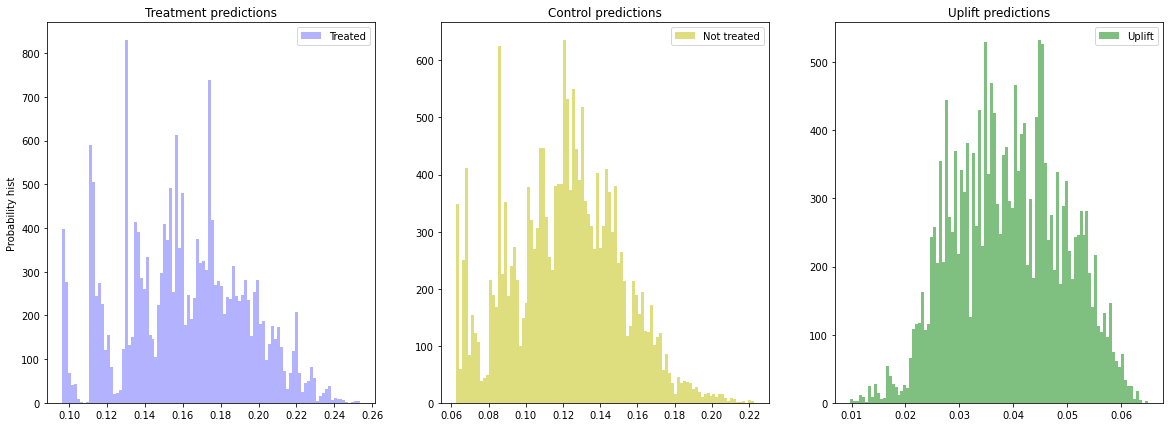

In [16]:
sm = SoloModel(RandomForestClassifier(max_depth=4, min_samples_leaf=200, criterion='gini', n_estimators=60, random_state=42))
sm = sm.fit(X_train, y_train, treat_train,)

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [17]:
from sklift.models import ClassTransformation


ct = ClassTransformation(RandomForestClassifier(max_depth=4, min_samples_leaf=200, criterion='gini', n_estimators=60, random_state=42))
ct = ct.fit(X_train, y_train, treat_train,)

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


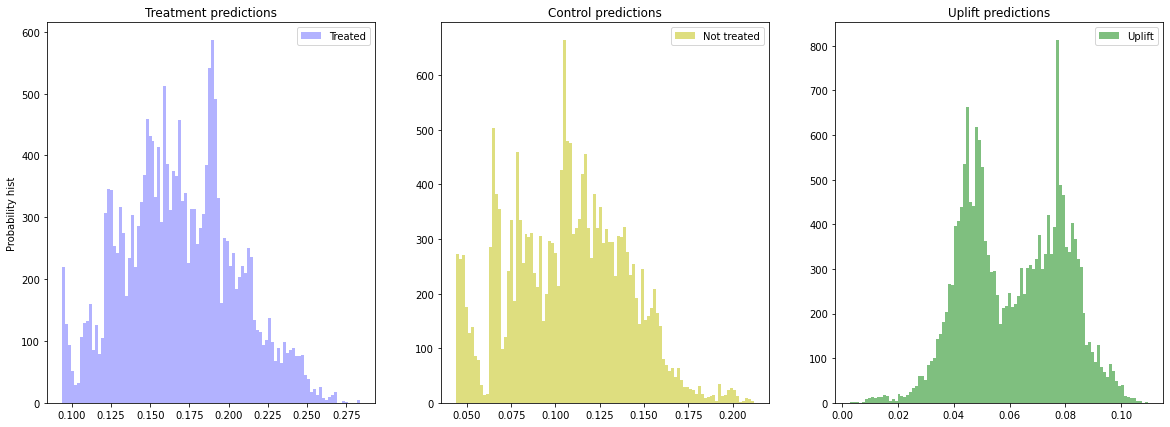

In [18]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(max_depth=4, min_samples_leaf=200, criterion='gini', n_estimators=60, random_state=42), 
    estimator_ctrl=RandomForestClassifier(max_depth=4, min_samples_leaf=200, criterion='gini', n_estimators=60, random_state=42), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [19]:
result = pd.DataFrame(models_results)
result.reset_index(drop=True, inplace=True)

In [20]:
result

,approach,uplift@30%
0,SoloModel,0.081215
1,ClassTransformation,0.143795
2,TwoModels,0.066150
